In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import sklearn
from statsmodels.tsa.arima.model import ARIMA

## <center>Time Series Ensemble LGBM - ARIMA</center>

In this article, I am going to showcase the predictive power of ensemble learning for time series forecasting. Ensemble learning leads to models with higher predictive accuracy, a lower likelihood of overfitting, and a diverse set of predictions.

I will be using a dataset provided by ASHRAE (The American Society of Heating, Refrigerating and Air-Conditioning Engineers) which has hourly meterage data on electricity, chilled water, steam, and hot water. In the following cell, we will import the necessary python packages, the meterage data, and the building metadata.

In [2]:
buildings = pd.read_csv("building_metadata.csv")
df = pd.read_csv('train.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[df['meter'] == 3].reset_index(drop=True) # 3 corresponds to the hot water meter

buildings['primary_use'].value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

In the visualization above, we can see that there are ~1400 unique buildings across numerous sectors. Not all of the buildings have clean data, with meterage data from some buildings containing more missing values than others. Let's visualize a sample of buildings with the least number of missing data points.

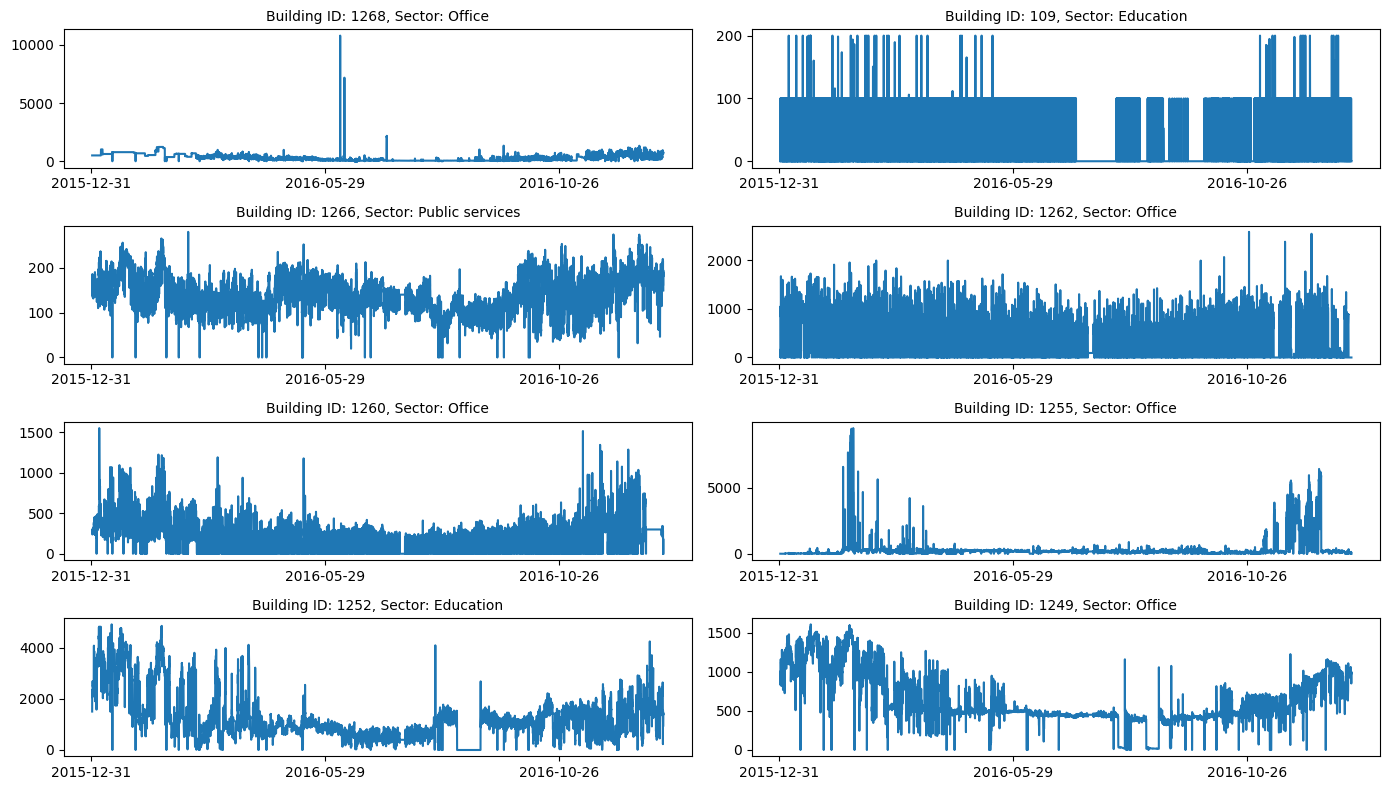

In [3]:
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(14,8))
building_ids = df['building_id'].value_counts().index[8:16]

for i in range(8):

    # Plotting buildings with most data points
    building_id = building_ids[i]
    sector = buildings[buildings['building_id'] == building_id]['primary_use'].values[0]
    
    plot_data = df[df['building_id'] == building_id][['timestamp','meter','meter_reading']].sort_values('timestamp')
    
    cax = plt.subplot(nrows, ncols, i+1)
    cax.plot(plot_data['timestamp'].values, plot_data['meter_reading'].values)
    cax.xaxis.set_major_locator(plt.MaxNLocator(3))
    cax.set_title('Building ID: {}, Sector: {}'.format(building_id, sector), fontsize=10)

plt.tight_layout()
plt.show()

We can see that most of the plots are quite different from one another. For example, even for the office buildings, we can see that the water usage across each building is quite different. This suggests that the sector of a building may not be very useful for prediction.

For the remainder of this article, we will be working with the hot water usage data for building 1266. This seems to have few errors and outliers or long periods of no usage. Using various features and external datasets (economic data, holidays, weather) we will hopefully create a model with high predictive accuracy. In the following cell, we isolate this sample, split the sample into a training and validation set, and plot the result.

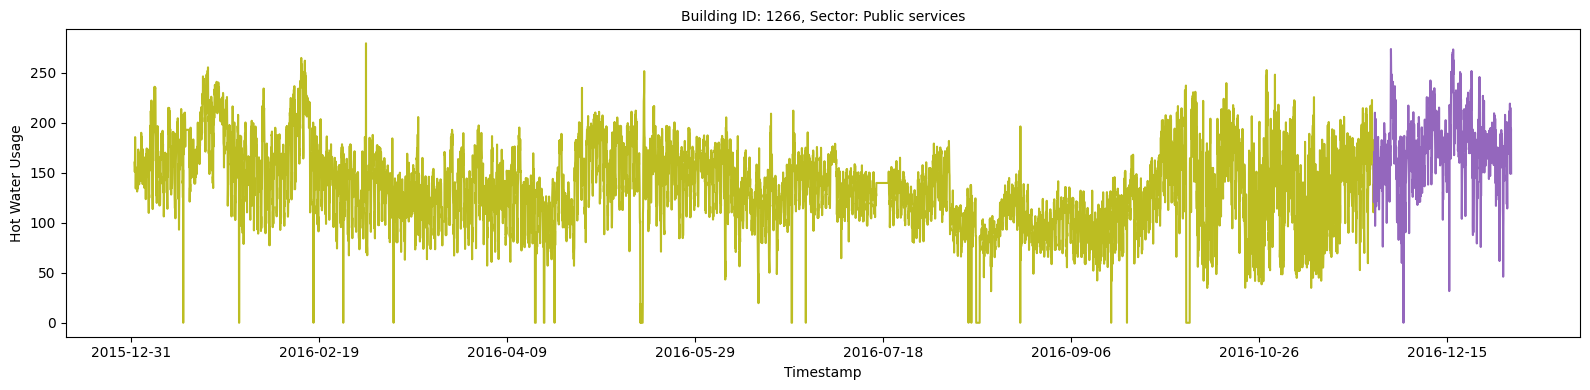

In [4]:
building_id = 1266
sector = buildings[buildings['building_id'] == building_id]['primary_use'].values[0]
building_1034_data = df[df['building_id'] == building_id][['timestamp','meter','meter_reading']].sort_values('timestamp').reset_index(drop=True)

train, valid = building_1034_data[:-int(len(building_1034_data)*0.10)], building_1034_data[-int(len(building_1034_data)*0.10):]

nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(16,4))

ax1 = plt.subplot(nrows, ncols, 1)
ax1.plot(train['timestamp'].values, train['meter_reading'].values, c='tab:olive')
ax1.plot(valid['timestamp'].values, valid['meter_reading'].values, c='tab:purple')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_ylabel('Hot Water Usage')
ax1.set_xlabel('Timestamp')
ax1.set_title('Building ID: {}, Sector: {}'.format(building_id, sector), fontsize=10)

plt.tight_layout()
plt.show()

It appears that there are 8–10 spikes in hot water usage over the course of the year. These could be due to low temperatures, special events, or something else entirely. There are also 10–20 points of 0 hot water usage for the building which could indicate holidays, weekends, or other events. These preliminary ideas can not be confirmed or denied using visualizations alone, and we will need to perform further exploration when developing the model.

We will now look at potential seasonality using time-based features from the data. We can create subplots in Matplotlib, and take the average metered hot water usage for each possible feature value.

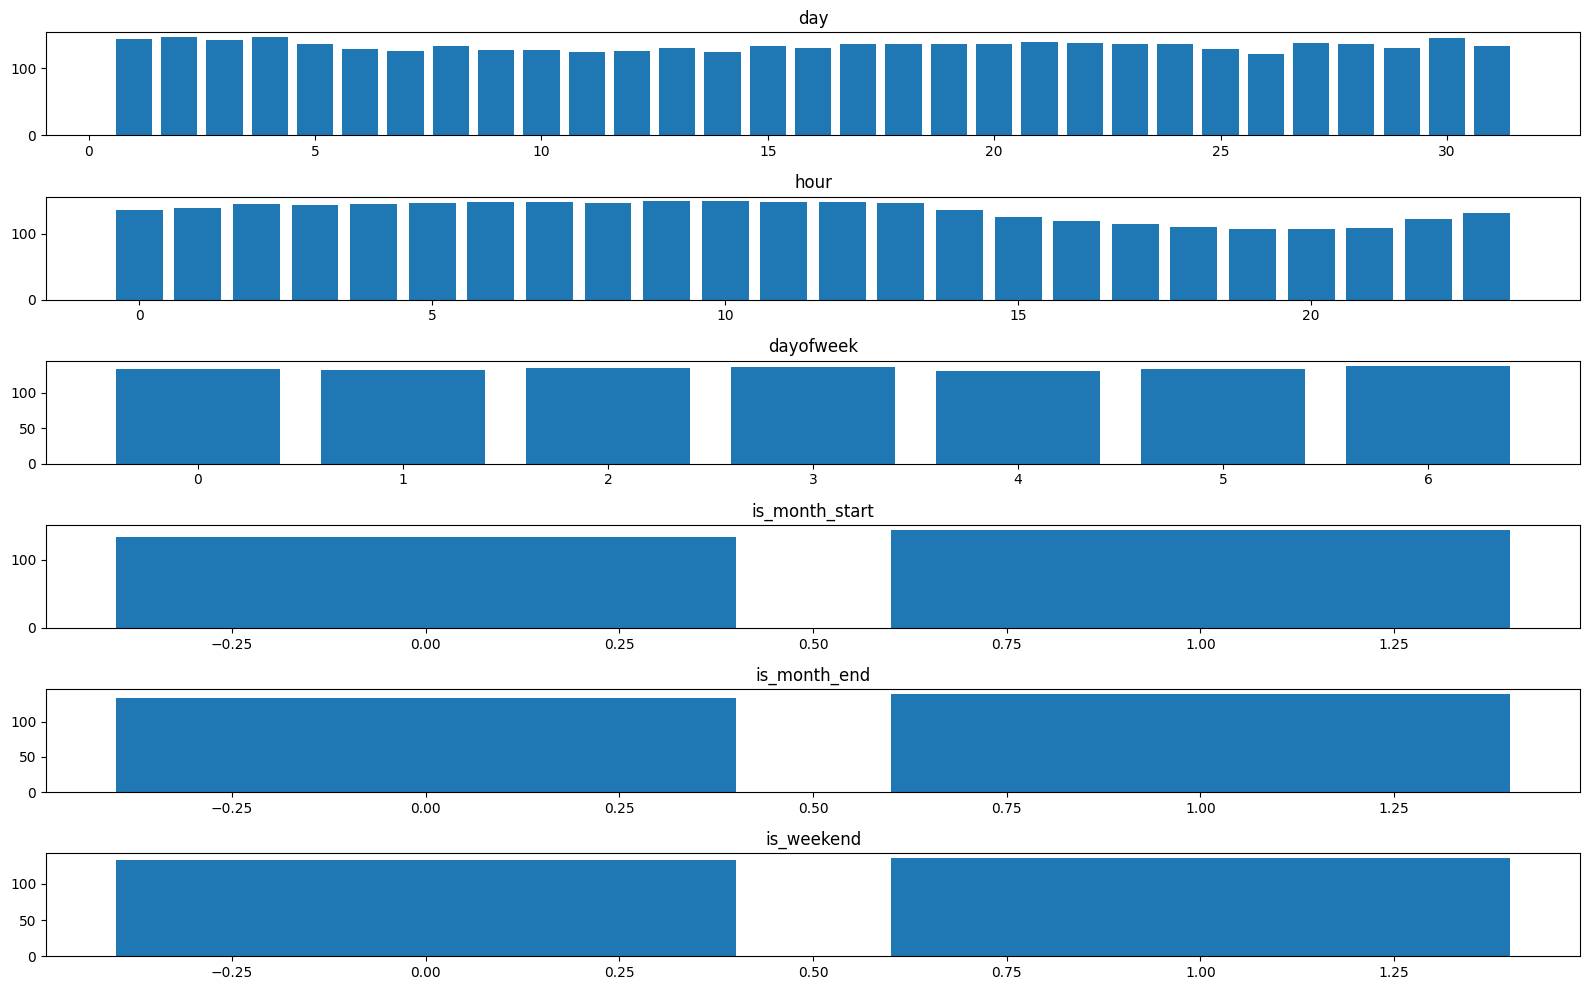

In [5]:
def add_timestamp_features(data):
    pd.options.mode.chained_assignment = None

    data['day'] = data['timestamp'].dt.day
    data['hour'] = data['timestamp'].dt.hour
    data['dayofweek'] = data['timestamp'].dt.dayofweek
    data['is_month_start'] = data['timestamp'].dt.is_month_start
    data['is_month_end'] = data['timestamp'].dt.is_month_end

    conditions = [(data['dayofweek'].eq(5) | data['dayofweek'].eq(6))]
    choices = [1]
    data['is_weekend'] = np.select(conditions, choices, default=0)
    return data

train = add_timestamp_features(train)

nrows, ncols = 6,1 
fig, ax = plt.subplots(nrows, ncols, figsize=(16,10))

for i, col in enumerate(['day','hour','dayofweek','is_month_start','is_month_end','is_weekend']):
    
    plot_data = train.groupby(col)['meter_reading'].mean()
    
    cax = plt.subplot(nrows, ncols, i+1)
    cax.bar(plot_data.index, plot_data.values)
    # Need to add automatic adding of labels of x-axis
    cax.set_title('{}'.format(col, fontsize=10))

plt.tight_layout()
plt.show()

pd.options.mode.chained_assignment = 'warn'

There seems to be more hot water usage during morning hours (AM) versus the afternoon hours (PM). Interestingly, there also seems to be higher hot water usage on Sunday than on any other day in the week. The day, day of the week, and other features may be important or they could be just noise, but we can not determine this from visualizations alone. By using these features alone we can generate a baseline LGBM model.
Baseline LGBM Model

LGBM is a gradient boosting framework based on the decision tree algorithm. This framework differs from XGB as models as it grows tree leaf-wise rather than depth-wise. This results in faster training times and high accuracy. For more information on the difference between these models, check out this [article](https://neptune.ai/blog/xgboost-vs-lightgbm).

In [6]:
valid = add_timestamp_features(valid)

x_train, y_train = train.drop(columns=['meter_reading']), train['meter_reading'].values
x_valid, y_valid = valid.drop(columns=['meter_reading']), valid['meter_reading'].values

params = {'num_leaves': 30,
          'n_estimators': 400,
          'max_depth': 8,
          'min_child_samples': 200,
          'learning_rate': 0.1,
          'subsample': 0.50,
          'colsample_bytree': 0.75
         }

model = lgb.LGBMRegressor(**params)
model = model.fit(x_train.drop(columns=['timestamp']), y_train)

We can then use the trained model to predict the hot water usage for every hour in the validation set and plot the predictions with the true labels. The plot title also shows the RMSE (root mean squared error) for the predictions. This will give us a concrete metric that will use to measure model accuracy. Note that we are not yet doing an n-step ahead prediction, and we are purely using features engineered from the timestamp.

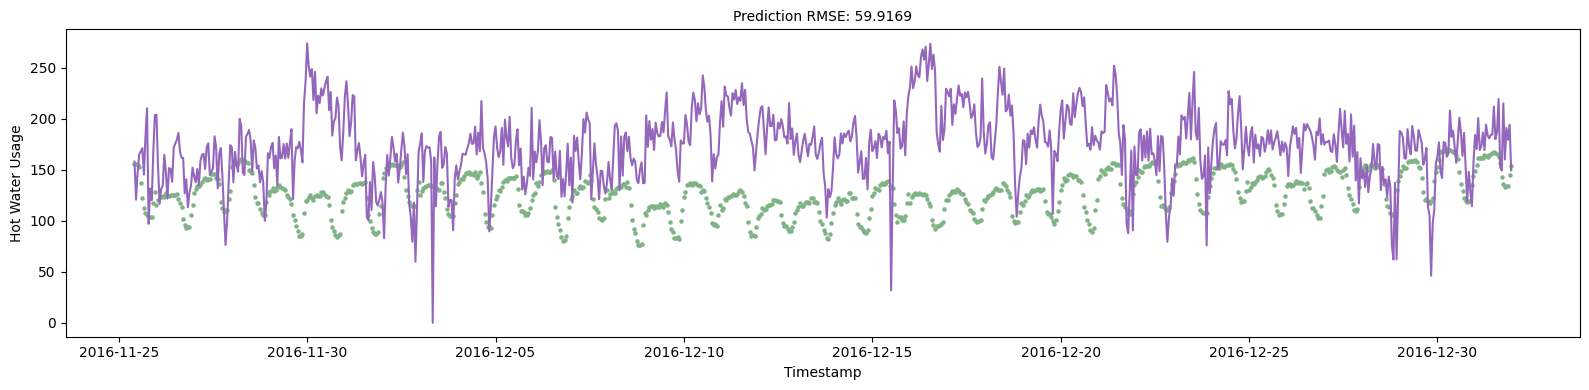

In [7]:
def plot_predictions(x_valid, y_valid, valid_preds, building_id, sector):
    
    rmse = sklearn.metrics.mean_squared_error(y_valid, valid_preds, squared=False)
    
    nrows, ncols = 1, 1
    fig, ax = plt.subplots(nrows, ncols, figsize=(16,4))

    ax1 = plt.subplot(nrows, ncols, 1)
    ax1.plot(x_valid['timestamp'].values, y_valid, c='tab:purple')
    ax1.scatter(x_valid['timestamp'].values, valid_preds, s=5, c='#7FB285')
    ax1.set_ylabel('Hot Water Usage')
    ax1.set_xlabel('Timestamp')
    ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax1.set_title('Prediction RMSE: {:.4f}'.format(rmse), fontsize=10)

    plt.tight_layout()
    plt.show()
    
valid_preds = model.predict(x_valid.drop(columns=['timestamp']))    
plot_predictions(x_valid, y_valid, valid_preds, building_id, sector)

#### Adding Holidays

In the next section, we will be using an external data source of US holiday dates (CC0: Public Domain). This could be a useful feature in explaining the troughs in hot water demand and was the main reason we will try and incorporate this feature. After merging this data into the training set, we will update the model and make new predictions.

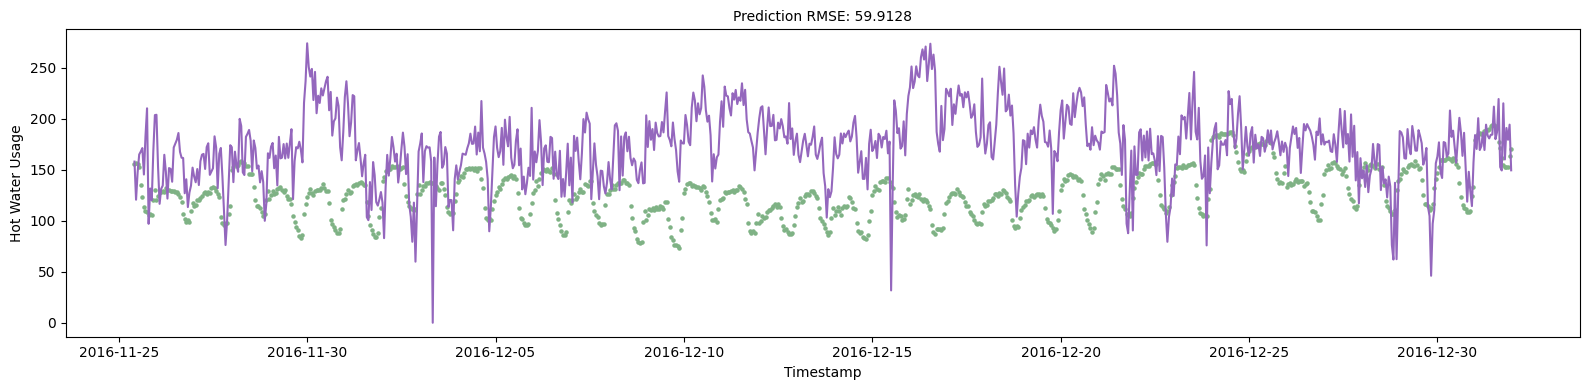

In [8]:
holidays = pd.read_csv("US Holiday Dates (2004-2021).csv")
holidays = holidays[holidays['Year']==2016].sort_values('Date').reset_index(drop=True)

x_train['is_holiday'] = x_train['timestamp'].dt.floor('1d').isin(holidays['Date'])
x_valid['is_holiday'] = x_valid['timestamp'].dt.floor('1d').isin(holidays['Date'])

model = lgb.LGBMRegressor(**params)
model = model.fit(x_train.drop(columns=['timestamp']), y_train)

valid_preds = model.predict(x_valid.drop(columns=['timestamp']))    
plot_predictions(x_valid, y_valid, valid_preds, building_id, sector)

This model improved on the previous RMSE by 0.0041. This is quite an underwhelming improvement, but we will keep this feature for now in case it is valuable in combination with other features we add.

#### Weather Data

The second data source that I will add is weather data from the ASHRAE dataset (CC0: Public Domain). This provides real-time historical weather measurements from towers closest to the buildings in the dataset.

We have to be careful here as the data we have is from real-time measurements and not a 10-hour ahead forecast. If we simply used this weather information as a feature we would be committing data leakage! Therefore we will simulate error in the weather data by adding a small amount of Gaussian noise to each column. This should make the model less dependent on the weather data and less prone to overfitting. 

We can then fit the LGBM model with the added features, score the RMSE of the new predictions, and plot the predictions against their true values.

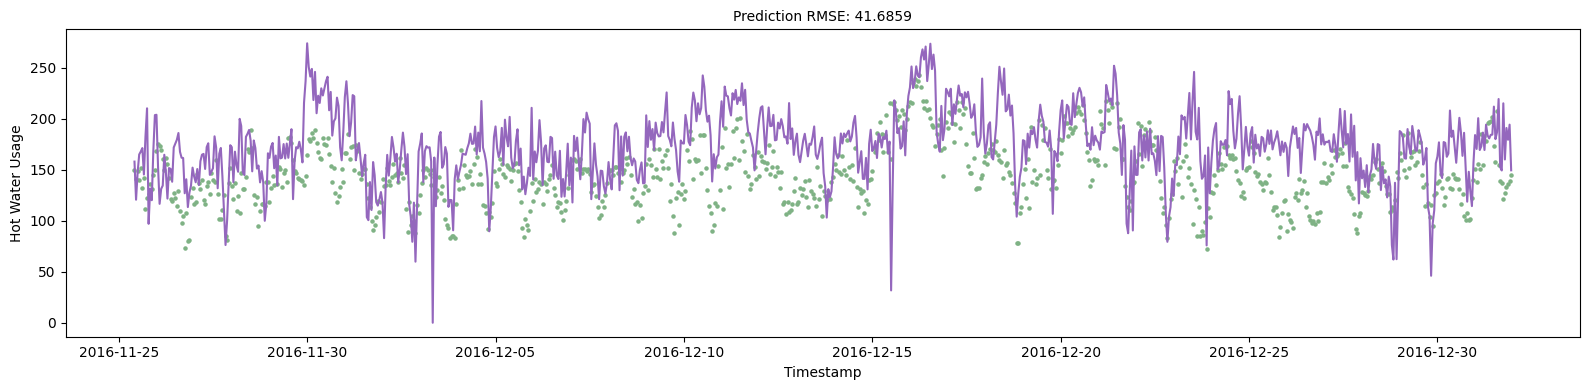

In [9]:
weather = pd.read_csv('weather_train.csv')
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

site_id = buildings[buildings['building_id'] == building_id]['site_id'].values[0]
weather = weather[weather['site_id'] == site_id].reset_index(drop=True)

for col in ['air_temperature', 'cloud_coverage','dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure','wind_direction', 'wind_speed']:
    mu = weather[col].mean()
    sig = weather[col].std()
    noise = np.random.normal(mu, sig, [len(weather)]) * 0.2
    weather[col] += noise

x_train = x_train.merge(weather, on=['timestamp'], how='left')
x_valid = x_valid.merge(weather, on=['timestamp'], how='left')

model = lgb.LGBMRegressor(**params)
model = model.fit(x_train.drop(columns=['timestamp']), y_train)

valid_preds = model.predict(x_valid.drop(columns=['timestamp']))    
plot_predictions(x_valid, y_valid, valid_preds, building_id, sector)

Wow! That's a significant increase of ~20 points on the RMSE from the previous iteration. Since we added 7 features to this iteration of the model it's not easy to see which contributed the most to the improved accuracy. Thankfully LGBM models have feature importance built into the models themselves. In the following plot, we visualize each feature's importance. We can see that all 7 features are important to the model, but the sea level pressure, air temperature, and wind direction have the most significant effect.

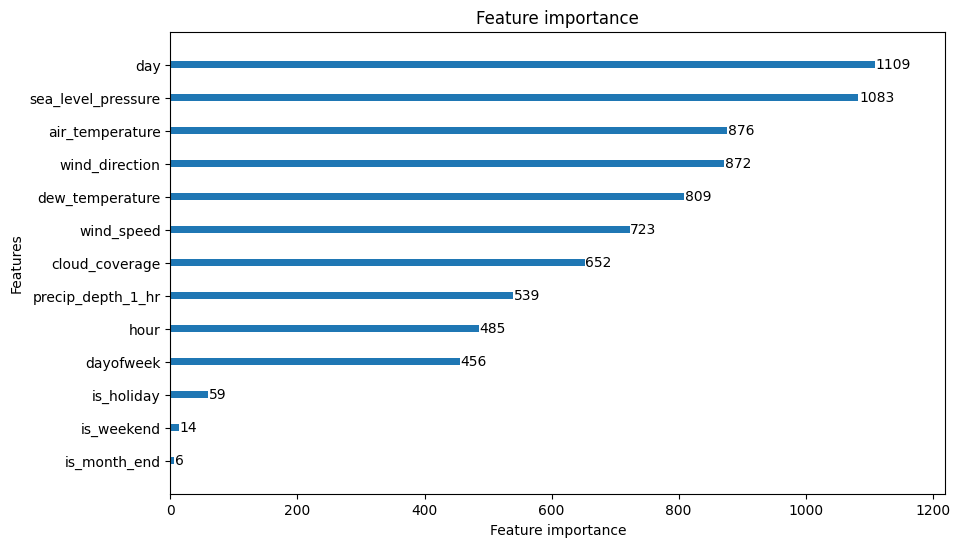

In [10]:
lgb.plot_importance(model, figsize=(10,6))
plt.grid(False)
plt.show()

#### LGBM - SARIMA Ensemble 

Finally, we will incorporate an ARIMA model in our predictions. In the real world, it does not make sense to make a prediction for the next 750 hours at a single point in time. It is more likely that you would forecast the one data point n-hours ahead of time. The further ahead the prediction you make, the less accurate it is likely to be.

One of the benefits of doing an n-step ahead prediction is that you can incorporate more localized information into your model. We will do this by ensembling the LGBM model with a SARIMA (seasonal autoregressive integrated moving average) model. SARIMA is based on the ARIMA model architecture, but it incorporates a seasonal component. ARIMA-based models are the gold standard of time series forecasting and yield accurate predictions. In the next cell, we are iteratively making 10-step ahead predictions on the entire validation dataset and seeing how well the model performs on its own.

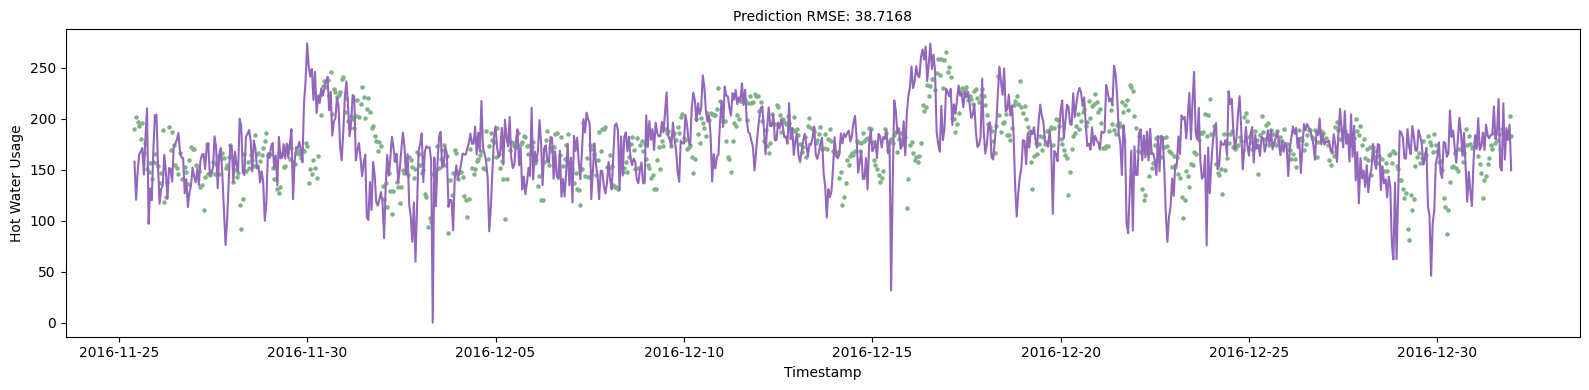

In [11]:
steps_ahead = 10
sarima_model = ARIMA(y_train[-250:-steps_ahead], order=(1,1,1), seasonal_order=(0, 1, 2, 24)).fit()
sarima_valid_preds = []

for i in range(len(y_train) - steps_ahead, len(y_train)):
    sarima_model = sarima_model.append([y_train[i]])
    sarima_valid_preds.append(sarima_model.forecast(steps_ahead)[0])
    
for i in range(len(y_valid) - steps_ahead):
    sarima_model = sarima_model.append([y_valid[i]])
    sarima_valid_preds.append(sarima_model.forecast(steps_ahead)[0])
    

rmse = sklearn.metrics.mean_squared_error(y_valid, sarima_valid_preds, squared=False)

nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(16,4))

ax1 = plt.subplot(nrows, ncols, 1)
ax1.plot(x_valid['timestamp'].values, y_valid, c='tab:purple')
ax1.scatter(x_valid['timestamp'].values, sarima_valid_preds, s=5, c='#7FB285')
ax1.set_ylabel('Hot Water Usage')
ax1.set_xlabel('Timestamp')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_title('Prediction RMSE: {:.4f}'.format(rmse), fontsize=10)

plt.tight_layout()
plt.show()

The gold standard of time series forecasting strikes again! The model achieves an RMSE of ~38 which outperforms the LGBM model by almost 3 points.

One might think that dropping the LGBM model is the way to go, but we can likely achieve even better model accuracy by ensembling the two models. Ensembling is when you take the average predictions of multiple models to make a final prediction. This often increases model accuracy and reduces overfitting.

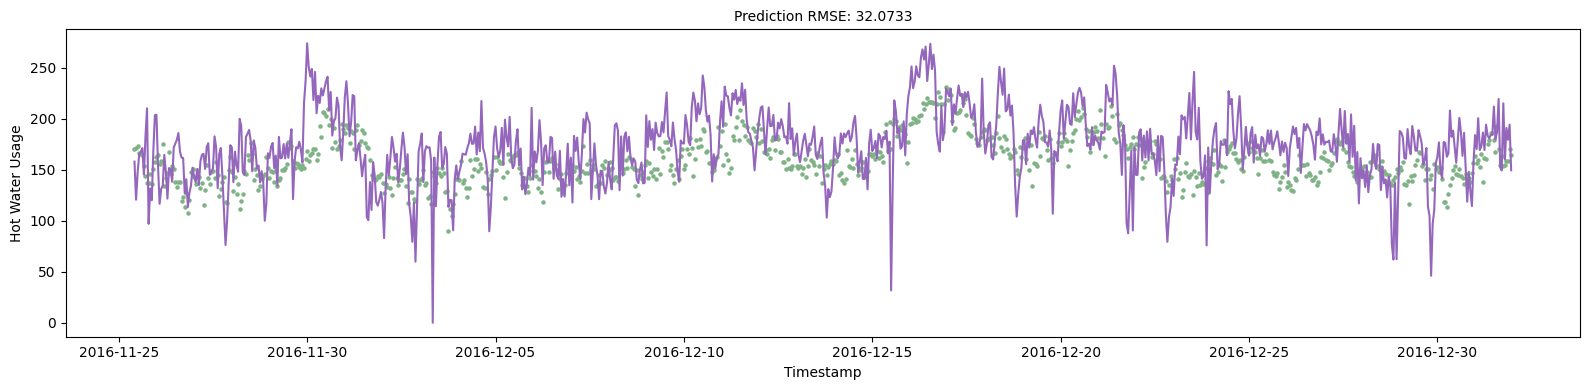

In [12]:
ensemble_preds = np.add(valid_preds, sarima_valid_preds)/2
rmse = sklearn.metrics.mean_squared_error(y_valid, ensemble_preds, squared=False)

nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(16,4))

ax1 = plt.subplot(nrows, ncols, 1)
ax1.plot(x_valid['timestamp'].values, y_valid, c='tab:purple')
ax1.scatter(x_valid['timestamp'].values, ensemble_preds, s=5, c='#7FB285')
ax1.set_ylabel('Hot Water Usage')
ax1.set_xlabel('Timestamp')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_title('Prediction RMSE: {:.4f}'.format(rmse), fontsize=10)

plt.tight_layout()
plt.show()

Wow! By ensembling the two models we were able to improve the RMSE of SARIMA by ~7 points and of LGBM by ~9 points. This is a significant improvement and showcases the power of ensemble learning.


### Final Thoughts

Ensemble learning is just as powerful in AI/ML as in the real world. In the real world when you solve a problem with a diverse group of people you are likely to create more effective solutions. This is due to each group member's unique experience and diverse skill sets. This is no different from ensemble learning. By combining different model architectures and feature combinations you are creating a diverse set of predictions.
If you want further information I have included some additional resources below. The code for this article can be found here.


### Resources

[Ensemble Learning Wiki](https://en.wikipedia.org/wiki/Ensemble_learning)

[Time Series Forecasting w/ ARIMA, SARIMA and SARIMAX](https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6)

[LGBM Documentation](https://lightgbm.readthedocs.io/en/latest/)

[StatsModels Documentation](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html)